<a href="https://colab.research.google.com/github/trungphan9x/ML_project1/blob/master/trung_colab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS582 Machine Learning - Mini Project 1

Professor: Anthony Sander

Team:


*   Khoa Nam Nguyen
*   Thai Trung Phan

Dataset: https://www.kaggle.com/camnugent/california-housing-prices



# Loading all libraries

In [3]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.24.0
!pip install auto-sklearn

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer



from autosklearn.experimental.askl2 import AutoSklearn2Classifier
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

Found existing installation: scikit-learn 0.24.0
Uninstalling scikit-learn-0.24.0:
  Successfully uninstalled scikit-learn-0.24.0
  Using cached scikit_learn-0.24.0-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [4]:
!pip install lime

In [5]:
!pip install shap

# STEP 1: LOADING DATASET

Min of 500 samples , must include at least one categorical feature

In [23]:
!git clone https://github.com/trungphan9x/ML_project1.git

fatal: destination path 'ML_project1' already exists and is not an empty directory.


In [24]:
housing = pd.read_csv('/content/ML_project1/dataset/Cali_housing_prices/housing.csv')

# STEP 2: EDA

# Identify if there are any missing values


> There are 20,640 instances in the dataset. Notice that the total_bed rooms attribute has only 20,433 nonnull values, meaning that 207 districts are missing this feature. We will need to take care of this.






In [ ]:
housing.info()

# Identify categorical feature



> All attributes are numerical, except the ocean_proximity field. When you looked at the top five rows, you probably noticed that the values in the ocean_proximity column were repetitive, which means that it is probably a categorical attribute 

In [ ]:
housing.head()



> Check what categories exist and how many districts belong to each category



In [ ]:
housing['ocean_proximity'].value_counts()

# Summary of the numerical atributes

In [ ]:
housing.describe()

# Ploting a histogram of each numerical atribute

In [ ]:
housing.hist(bins=50, figsize=(20,15)) 
plt.show()



> There are a few things you might notice in these histograms:


1.   The median house value is our target attribute (our labels).
2.   The median income attribute: the numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).
3.   These attributes have very different scales.
4.   Finally, many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.






# Visualizing Geographical Data

Create a scatterplot of all districts to visualize the data

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

This looks like California actually. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points:

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now that’s much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.


Now let’s look at the housing prices (Figure 2-13). The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

# Correlations

In [ ]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value:

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up

When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

Another way to check for correlation between attributes is to use the pandas scatter_matrix() function

In [ ]:
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

In [ ]:
 housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

# Atribute Combination

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [26]:
corr_matrix = housing.corr()

In [27]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms.

Apparently houses with a lower bedroom/room ratio tend to be more expensive. 

The larger the houses, the more expensive they are.

# STEP 3: DATA PREPARATION

# Handle the categorical columns

In [28]:
#le = LabelEncoder()
#housing['ocean_proximity'] = le.fit_transform(housing['ocean_proximity'])
housing = pd.get_dummies(housing, columns=['ocean_proximity'])


In [12]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,5.045455,0.224625,2.560606,0,1,0,0,0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,6.114035,0.215208,3.122807,0,1,0,0,0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,5.205543,0.215173,2.325635,0,1,0,0,0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,5.329513,0.219892,2.123209,0,1,0,0,0


#  Processing missing values

Create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [29]:
imputer = SimpleImputer(strategy="median")

Fit the imputer instance to the training data using the fit() method:

In [30]:
imputer.fit(housing)

SimpleImputer(strategy='median')

In [31]:
imputer.statistics_

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  5.22912879e+00,  2.03162434e-01,  2.81811565e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

Use this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [32]:
X = imputer.transform(housing)

The result is a plain NumPy array containing the transformed features. If you want to put it back into a pandas DataFrame, it’s simple:

In [33]:
housing = pd.DataFrame(X, columns=housing.columns, index=housing.index)
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,0.146591,2.555556,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,0.155797,2.109842,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,0.129516,2.802260,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,0.184458,2.547945,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,0.172096,2.181467,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,5.045455,0.224625,2.560606,0.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,6.114035,0.215208,3.122807,0.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,5.205543,0.215173,2.325635,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,5.329513,0.219892,2.123209,0.0,1.0,0.0,0.0,0.0


In [34]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   rooms_per_household         20640 non-null  float64
 10  bedrooms_per_room           20640 non-null  float64
 11  population_per_household    20640 non-null  float64
 12  ocean_proximity_<1H OCEAN   20640 non-null  float64
 13  ocean_proximity_INLAND      206

# Convert Regression dataset to Binary Classification dataset

In [35]:
housing['median_house_value'] = np.where(housing['median_house_value']>200000.0,1,0)
housing.rename(columns={'median_house_value': 'expensive'}, inplace= True)

In [36]:
housing['expensive'].value_counts()

0    11931
1     8709
Name: expensive, dtype: int64

In [42]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20433 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   rooms_per_household         20640 non-null  float64
 10  bedrooms_per_room           20433 non-null  float64
 11  population_per_household    20640 non-null  float64
 12  ocean_proximity_<1H OCEAN   20640 non-null  uint8  
 13  ocean_proximity_INLAND      206

# Create trainset and testset

The median income is a very important attribute to predict median housing prices. We may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. So we are gonna create an income category attribute with five categories:

In [37]:
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5])

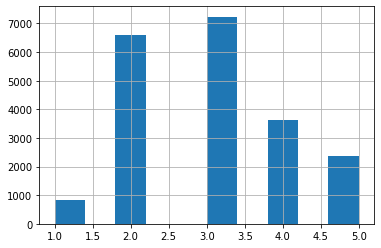

In [38]:
 housing["income_cat"].hist()

In [39]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [45]:
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

In [46]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [47]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

Then remove the income_cat attribute so the data is back to its original

In [48]:
for set_ in (strat_train_set, strat_test_set): 
  set_.drop("income_cat", axis=1, inplace=True)

Separate the predictors and the labels, since we don’t necessarily want to apply the same transformations to the predictors and the target values:

In [49]:
housing = strat_train_set.drop("expensive", axis=1)
housing_labels = strat_train_set["expensive"].copy()

In [50]:
X_test = strat_test_set.drop("expensive", axis=1)
y_test = strat_test_set["expensive"].copy()

In [52]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,4.625369,0.223852,2.094395,1.0,0.0,0.0,0.0,0.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,6.008850,0.159057,2.707965,1.0,0.0,0.0,0.0,0.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,4.225108,0.241291,2.025974,0.0,0.0,0.0,0.0,1.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,5.232295,0.200866,4.135977,0.0,1.0,0.0,0.0,0.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,4.505810,0.231341,3.047847,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,6.052381,0.185681,2.728571,0.0,1.0,0.0,0.0,0.0
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,4.635659,0.245819,4.077519,0.0,1.0,0.0,0.0,0.0
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,6.346405,0.179609,2.742484,0.0,1.0,0.0,0.0,0.0
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,5.505618,0.193878,3.808989,1.0,0.0,0.0,0.0,0.0


In [53]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,6.715625,0.156972,2.275000,1.0,0.0,0.0,0.0,0.0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,6.388633,0.157490,2.563748,1.0,0.0,0.0,0.0,0.0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,4.973744,0.212532,2.408676,1.0,0.0,0.0,0.0,0.0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,5.546584,0.171333,3.161491,0.0,1.0,0.0,0.0,0.0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,5.877483,0.176901,3.533113,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,4.640000,0.234362,2.245581,0.0,1.0,0.0,0.0,0.0
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,4.808917,0.226049,2.976645,0.0,0.0,0.0,0.0,1.0
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,4.492690,0.219330,2.172515,1.0,0.0,0.0,0.0,0.0
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,6.535885,0.155564,2.870813,0.0,1.0,0.0,0.0,0.0


# Feature Scaling

In [57]:
# normalize data
std_scaler = StandardScaler()

housing_prepared = std_scaler.fit_transform(housing)
X_test_prepared = std_scaler.fit_transform(X_test)

In [58]:
housing_prepared = pd.DataFrame(housing_prepared, columns=housing.columns, index=housing.index)
housing_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,-1.156043,0.771950,0.743331,-0.493234,-0.445490,-0.636211,-0.420698,-0.614937,-0.312055,0.193784,-0.086499,1.126667,-0.684006,-0.011006,-0.354889,-0.384217
18632,-1.176025,0.659695,-1.165317,-0.908967,-1.036986,-0.998331,-1.022227,1.336459,0.217683,-0.940771,-0.033534,1.126667,-0.684006,-0.011006,-0.354889,-0.384217
14650,1.186849,-1.342183,0.186642,-0.313660,-0.153393,-0.433639,-0.093318,-0.532046,-0.465315,0.499140,-0.092405,-0.887574,-0.684006,-0.011006,-0.354889,2.602693
3230,-0.017068,0.313576,-0.290520,-0.362762,-0.396807,0.036041,-0.383436,-1.045566,-0.079661,-0.208697,0.089736,-0.887574,1.461976,-0.011006,-0.354889,-0.384217
3555,0.492474,-0.659299,-0.926736,1.856193,2.412192,2.724154,2.570975,-0.441437,-0.357834,0.324916,-0.004194,1.126667,-0.684006,-0.011006,-0.354889,-0.384217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,0.722267,-0.673331,1.379547,-0.632123,-0.725416,-0.759010,-0.764049,0.554158,0.234352,-0.474599,-0.031755,-0.887574,1.461976,-0.011006,-0.354889,-0.384217
12053,1.007011,-0.823004,0.902385,-0.667196,-0.584236,-0.329664,-0.636291,-0.948815,-0.308114,0.578433,0.084689,-0.887574,1.461976,-0.011006,-0.354889,-0.384217
13908,1.586489,-0.724781,-1.562952,1.043901,0.822698,0.607904,0.713156,-0.316705,0.346934,-0.580919,-0.030554,-0.887574,1.461976,-0.011006,-0.354889,-0.384217
11159,0.782213,-0.851068,0.186642,-0.309919,-0.374900,-0.057178,-0.375451,0.098121,0.024995,-0.331070,0.061509,1.126667,-0.684006,-0.011006,-0.354889,-0.384217


In [59]:
X_test_prepared = pd.DataFrame(X_test_prepared, columns=X_test.columns, index=X_test.index)
X_test_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5241,0.574715,-0.696209,0.032860,1.602628,1.026670,0.614715,1.105510,2.357904,0.730902,-0.943290,-0.437080,1.104244,-0.673440,-0.026968,-0.346723,-0.385462
10970,0.838394,-0.860742,0.824710,0.627178,0.236540,0.184453,0.347308,0.404516,0.551471,-0.934662,-0.254840,1.104244,-0.673440,-0.026968,-0.346723,-0.385462
20351,0.246359,-0.653901,-0.125511,0.711592,0.836331,0.552891,0.899397,-0.446556,-0.224920,-0.017125,-0.352712,1.104244,-0.673440,-0.026968,-0.346723,-0.385462
6568,0.694117,-0.658602,1.854116,-0.384511,-0.535883,-0.359433,-0.459968,0.160083,0.089414,-0.703905,0.122418,-0.905597,1.484914,-0.026968,-0.346723,-0.385462
13285,0.927946,-0.719714,0.270415,-0.389200,-0.518177,-0.318495,-0.509043,0.099254,0.270989,-0.611074,0.356963,-0.905597,1.484914,-0.026968,-0.346723,-0.385462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20519,-0.987461,1.400413,0.349600,0.980608,1.374150,0.806872,1.387689,-0.999550,-0.408056,0.346792,-0.455647,-0.905597,1.484914,-0.026968,-0.346723,-0.385462
17430,-0.445177,-0.447059,0.112045,-0.180297,-0.079954,-0.038615,-0.094363,-0.998379,-0.315366,0.208201,0.005755,-0.905597,-0.673440,-0.026968,-0.346723,2.594289
4019,0.524964,-0.668003,0.191230,0.164180,0.278592,0.031563,0.428281,0.557413,-0.488889,0.096198,-0.501762,1.104244,-0.673440,-0.026968,-0.346723,-0.385462
12107,1.107049,-0.757321,-0.125511,1.183542,0.668124,0.795175,0.801248,0.457681,0.632273,-0.966770,-0.061039,-0.905597,1.484914,-0.026968,-0.346723,-0.385462


# STEP 4: MODEL TUNING

Using GridSearchCV to find a great combination of hyperparameter values

In [ ]:
from sklearn.model_selection import GridSearchCV
def best_estimator(estimator,param_grid,X,y,cv):
  grid = GridSearchCV(estimator, param_grid, cv = cv, scoring = 'accuracy', n_jobs=-1)
  grid.fit(X,y)
  best_estimator = grid.best_estimator_
  best_score = grid.best_score_
  print("Best Params:", grid.best_params_)
  print("Best Score:", grid.best_score_)
  print("Best Estimator:", grid.best_estimator_)
  return best_estimator, best_score

Plot learning curve: `https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html`

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axe=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axe is None:
        _, axe = plt.subplots(figsize=(20, 5))

    plt.title("Learning Curve with "+ title)
    axe.set_xlabel("Training examples")
    axe.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axe.grid()
    axe.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axe.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axe.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axe.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axe.legend(loc="best")

    return plt


Plot validation curve: `https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html`

In [ ]:

from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, title, X, y, param_name=None, param_range=None, cv= None, n_jobs=None):
  train_scores, test_scores = validation_curve(
      estimator, X, y, param_name=param_name, param_range=param_range,
      scoring="accuracy", n_jobs=1)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.subplots(figsize=(20, 5))
  plt.title("Validation Curve with "+ title)
  plt.xlabel(param_name)
  plt.ylabel("Score")
  plt.ylim(0.0, 1.1)
  lw = 2
  plt.semilogx(param_range, train_scores_mean, label="Training score",
              color="darkorange", lw=lw)
  plt.fill_between(param_range, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.2,
                  color="darkorange", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
              color="navy", lw=lw)
  plt.fill_between(param_range, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.2,
                  color="navy", lw=lw)
  plt.legend(loc="best")
  plt.show()


# 1) SVC

In [ ]:
from sklearn.svm import SVC
param_svc = {
    'C': [0.001, 0.1, 1, 10, 100] #regularization factor
}
svc_estimator, svc_score = best_estimator(SVC(), param_svc, housing_prepared, housing_labels, 5) 

In [ ]:
plot_learning_curve(svc_estimator, "SVC", housing_prepared, housing_labels)

In [ ]:
plot_validation_curve(svc_estimator, "SVC", housing_prepared, housing_labels, param_name="C", param_range=[0.001, 0.1, 1, 10, 100])

# 2) KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_range = np.arange(1,30)
param_knn = dict(n_neighbors = k_range)
knn_estimator, knn_score = best_estimator(KNeighborsClassifier(), param_knn, housing_prepared, housing_labels, 5)

In [ ]:
plot_learning_curve(knn_estimator, "KNN", housing_prepared, housing_labels)

In [ ]:
param_range = [1,3,7,14,20]
plot_validation_curve(knn_estimator, "KNN", housing_prepared, housing_labels, param_name="n_neighbors", param_range = param_range)

# 3) Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_params = {
    'C': np.logspace(-3,3,7),
    'penalty':['l1','l2']# l1 lasso l2 ridge
}
log_estimator,log_score = best_estimator(LogisticRegression(max_iter=1000), log_params,housing_prepared, housing_labels,5)

In [ ]:
plot_learning_curve(log_estimator, "Logistic Regression", housing_prepared, housing_labels)

In [ ]:
param_range = np.logspace(-3,3,7)
plot_validation_curve(log_estimator, "Logistic Regression", housing_prepared, housing_labels, param_name="C", param_range = param_range)

# 4) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_params = {
     'max_depth':np.arange(1,20)
}
dt_estimator,dt_score = best_estimator(DecisionTreeClassifier(), dtree_params, housing_prepared, housing_labels, 5)

In [ ]:
plot_learning_curve(dt_estimator, "Decision Tree", housing_prepared, housing_labels)

In [ ]:
param_range = [1,3,8,12,20]
plot_validation_curve(dt_estimator, "Decision Tree", housing_prepared, housing_labels, param_name="max_depth", param_range = param_range)

# 5) MLP

`https://scikit-learn.org/stable/modules/neural_networks_supervised.html`

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_params = {
    'hidden_layer_sizes': [(5,),(10,),(20,)]
}
mlp_estimator, mlp_score = best_estimator(MLPClassifier(max_iter=1000), mlp_params, housing_prepared, housing_labels, 5)

In [ ]:
plot_learning_curve(mlp_estimator, "MLP", housing_prepared, housing_labels)

In [ ]:
param_range = [1, 20, 50,100]
plot_validation_curve(mlp_estimator, "MLP", housing_prepared, housing_labels, param_name="hidden_layer_sizes", param_range = param_range)

# 6) Ensemble - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rForest = [
        {'n_estimators': [3, 10, 30, 50, 80, 100, 500], 'max_features': [2, 4, 6, 8, 10, 12]},
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
rf_estimator, rf_score = best_estimator(RandomForestClassifier(), rForest, housing_prepared, housing_labels, 5)

In [ ]:
plot_learning_curve(rf_estimator, "Random Forest Classifier", housing_prepared, housing_labels)

In [ ]:
param_range = [3, 10, 30, 50, 80, 100, 500]
plot_validation_curve(rf_estimator, "Random Forest Classifier", housing_prepared, housing_labels, param_name="n_estimators", param_range = param_range)

# 7) Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

eclf = VotingClassifier(voting='hard', 
                        estimators=[('svc', svc_estimator), ('knn', knn_estimator), ('log', log_estimator), ('dt', dt_estimator), ('mlp', mlp_estimator), ('rf', rf_estimator)] )
eclf = eclf.fit(housing_prepared, housing_labels)
y_pred_voting = eclf.predict(X_test_prepared)
voting_score = accuracy_score(y_test, y_pred_voting)
print(f"Voting Accuracy Score = {voting_score}")

# 8) AutoML

In [ ]:
#Auto-sklearn 2.0 includes latest research on automatically configuring the AutoML system itself and contains a multitude of improvements which speed up the fitting the AutoML system.
# from autosklearn.experimental.askl2 import AutoSklearn2Classifier
# import autosklearn.classification
# import sklearn.model_selection
# import sklearn.datasets
# import sklearn.metrics

autoMl = autosklearn.classification.AutoSklearnClassifier()
autoMl.fit(housing_prepared, housing_labels)

y_pred_automl = autoMl.predict(X_test_prepared)
autoMl_score =  sklearn.metrics.accuracy_score(y_test, y_pred_automl)
print(f"AutoML Accuracy Score = {autoMl_score}")


# AUC Curve

`https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html`

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics
def plot_roc_curve(estimators, titles, X, y, ax=None):
    if ax is None: _, ax = plt.subplots(figsize=(5, 5))

    for i, estimator in enumerate(estimators):
      y_pred = estimator.predict(X)
      fpr, tpr, _ = roc_curve(y, y_pred)
      ax.plot(fpr, tpr, label=f"{titles[i]}, AUC=" + "{:.2f}".format(metrics.auc(fpr, tpr)))

    ax.set_title('AUC curve')
    ax.legend(loc='best')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate') 
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    return plt

estimators = [svc_estimator, knn_estimator, log_estimator, dt_estimator, mlp_estimator, rf_estimator]
titles = ['SVC','KNN','LOG','DT','MLP', 'RF']
plot_roc_curve(estimators, titles, X_test_prepared, y_test)
plt.show()


# SHAP

`https://www.explorium.ai/blog/interpretability-and-explainability-part-2/`

In [ ]:
import shap

row = 4
data_for_prediction = X_test_prepared.iloc[row]  # use 1 arbitrary row of data
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(dt_estimator)
shap_values = explainer.shap_values(data_for_prediction)
# The shap_values is a list with two arrays. It’s cumbersome to review raw arrays, but the shap package has a nice way to visualize the results.

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

In [ ]:
y_test